In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time

###Cifar 10 데이터셋 불러오기

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# 데이터 전처리 (이미지를 텐서로 변환 + 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] → [0.0, 1.0]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # R, G, B 각각 정규화
])

# CIFAR-10 학습 데이터셋 다운로드 & 불러오기
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# CIFAR-10 테스트 데이터셋
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# 클래스 라벨 이름
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:05<00:00, 28.7MB/s]


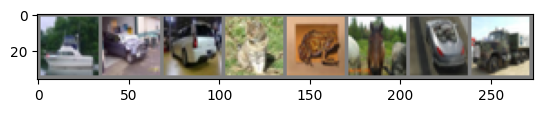

ship car car cat frog horse car truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지 보여주는 함수
def imshow(img):
    img = img / 2 + 0.5  # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 데이터 일부 불러오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 출력
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))

###RNN모델 정의

In [5]:
#########################
# 2. ResNet56 모델 정의 (CIFAR-10용)
#########################
# CIFAR-10에서는 일반적으로 초기 conv layer를 3x3, stride=1, padding=1로 사용합니다.
# ResNet56는 "6n+2" 레이어 구조에서 n=9로, 총 3개의 stage에 각각 9개의 residual block을 사용합니다.

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # 첫 번째 3x3 convolution
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # 두 번째 3x3 convolution
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # shortcut: 입력과 출력 크기가 다르면 1x1 convolution을 통해 맞춰줍니다.
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        # 초기 convolution: CIFAR-10은 32x32 이미지이므로 3x3 conv 사용
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        # 3개의 stage로 구성, 각 stage에서 block 개수는 num_blocks 리스트에 지정 (여기선 [9, 9, 9])
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        # 마지막에 global average pooling 후 linear layer로 분류
        self.linear = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # 첫 블록만 지정한 stride 사용, 나머지는 stride=1
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # feature map 전체에 대해 평균 풀링 (이미지 크기에 맞춰 자동)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet56():
    # ResNet-56: n = 9 => 6*9+2 = 56 레이어
    return ResNet(BasicBlock, [9, 9, 9])

###CNN 모델 정의

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# ---------------------------------------------
# 데이터 전처리: CIFAR-10을 위한 변환 설정
# ---------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] 범위를 [0.0, 1.0] 범위로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # R, G, B 각각 정규화
])

# 학습 데이터셋 다운로드 및 DataLoader 설정
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# 테스트 데이터셋 다운로드 및 DataLoader 설정
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# 클래스 라벨 이름
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# ---------------------------------------------
# CNN 모델 정의
# ---------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # 첫 번째 컨볼루션: 입력 채널 3 → 32 출력 feature maps, 3x3 커널, padding=1 유지
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # 두 번째 컨볼루션: 32 → 64 feature maps
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # 세 번째 컨볼루션: 64 → 128 feature maps
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # 최대 풀링 레이어: 2x2 풀링 (특징 맵의 크기를 절반으로 줄임)
        self.pool = nn.MaxPool2d(2, 2)

        # FC 레이어를 위한 feature 수 계산
        # CIFAR-10 입력: 32x32
        # conv1: 32x32, conv2 후 pool: 16x16, conv3 후 pool: 8x8
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # 첫 번째 Convolution + BatchNorm + ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        # 두 번째 Convolution + BatchNorm + ReLU
        x = F.relu(self.bn2(self.conv2(x)))
        # 첫 번째 Max Pooling (공간 차원 축소)
        x = self.pool(x)
        # 세 번째 Convolution + BatchNorm + ReLU
        x = F.relu(self.bn3(self.conv3(x)))
        # 두 번째 Max Pooling (더 축소)
        x = self.pool(x)
        # Flatten: 배치 크기를 유지하며 vector로 변환
        x = x.view(x.size(0), -1)
        # 첫 번째 FC 레이어 + ReLU
        x = F.relu(self.fc1(x))
        # 두 번째 FC 레이어 (출력: 클래스 수)
        x = self.fc2(x)
        return x

In [ ]:
# ---------------------------------------------
# 학습 및 테스트 함수 정의
# ---------------------------------------------
def train(net, trainloader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f"[{i+1}/{len(trainloader)}] Loss: {running_loss/100:.3f}")
            running_loss = 0.0

def test(net, testloader, device):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy on test set: {100 * correct / total:.2f}%")

# ---------------------------------------------
# 하이퍼파라미터, 모델 생성 및 학습 실행
# ---------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

net = SimpleCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 10  # 원하는 에폭 수

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(net, trainloader, criterion, optimizer, device)
    test(net, testloader, device)

###옵티마이저별 성능 비교

Using device: cuda

==> Training ResNet56 with SGD
Epoch 1/10 - Loss: 1.852 / Test Acc: 39.09%
Epoch 2/10 - Loss: 1.434 / Test Acc: 47.16%
Epoch 3/10 - Loss: 1.100 / Test Acc: 61.93%
Epoch 4/10 - Loss: 0.865 / Test Acc: 64.24%
Epoch 5/10 - Loss: 0.748 / Test Acc: 72.40%
Epoch 6/10 - Loss: 0.687 / Test Acc: 59.10%
Epoch 7/10 - Loss: 0.645 / Test Acc: 72.14%
Epoch 8/10 - Loss: 0.618 / Test Acc: 71.35%
Epoch 9/10 - Loss: 0.606 / Test Acc: 66.85%
Epoch 10/10 - Loss: 0.584 / Test Acc: 71.76%

==> Training ResNet56 with Adagrad
Epoch 1/10 - Loss: 1.503 / Test Acc: 49.92%
Epoch 2/10 - Loss: 1.014 / Test Acc: 46.62%
Epoch 3/10 - Loss: 0.818 / Test Acc: 69.50%
Epoch 4/10 - Loss: 0.697 / Test Acc: 73.86%
Epoch 5/10 - Loss: 0.609 / Test Acc: 74.14%
Epoch 6/10 - Loss: 0.541 / Test Acc: 73.63%
Epoch 7/10 - Loss: 0.478 / Test Acc: 78.17%
Epoch 8/10 - Loss: 0.430 / Test Acc: 74.93%
Epoch 9/10 - Loss: 0.381 / Test Acc: 76.48%
Epoch 10/10 - Loss: 0.336 / Test Acc: 77.21%

==> Training ResNet56 with Ada

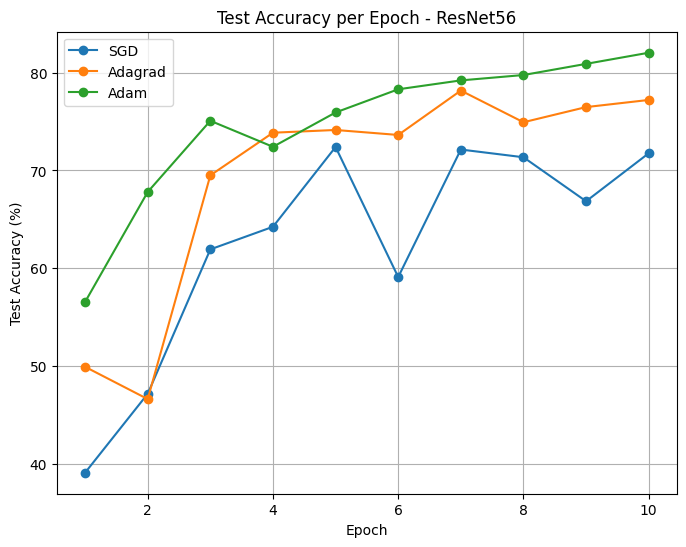

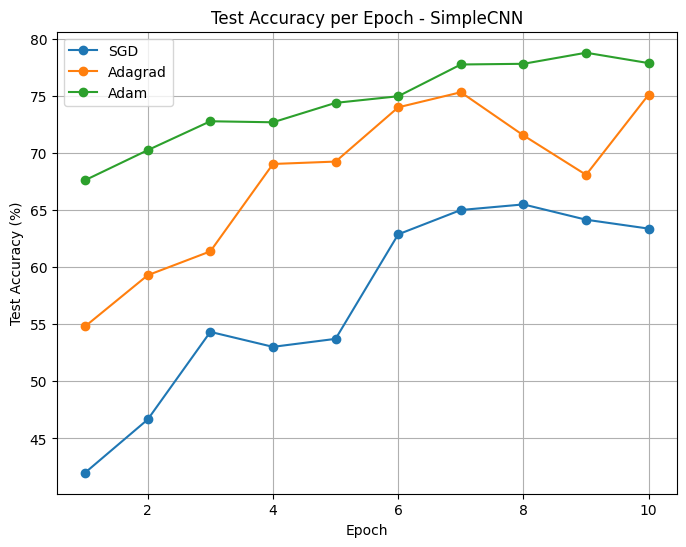

In [7]:
#######################################
# 3. 학습 및 평가 함수 정의
#######################################
def train_one_epoch(net, loader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(net, loader, device):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total

#######################################
# 4. 실험: 모델과 옵티마이저 조합별 학습 및 평가
#######################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 모델과 옵티마이저 종류 설정
models = {
    "ResNet56": ResNet56,       # 함수 형태로 호출해야 함
    "SimpleCNN": lambda: SimpleCNN(num_classes=10)
}

# 옵티마이저 구성: RMSprop 대신 SGD와 Adagrad만 사용
optimizers_dict = {
    'SGD': lambda params: optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=5e-4),
    'Adagrad': lambda params: optim.Adagrad(params, lr=0.01),
    'Adam': lambda params: optim.Adam(params, lr=0.001),

}

num_epochs = 10  # 데모용 에폭 수 (더 긴 학습도 가능)
results = {}  # 각 모델/옵티마이저 조합의 test accuracy 이력을 저장

for model_name, model_fn in models.items():
    results[model_name] = {}
    for opt_name, opt_fn in optimizers_dict.items():
        print(f"\n==> Training {model_name} with {opt_name}")
        net = model_fn().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = opt_fn(net.parameters())

        acc_history = []
        for epoch in range(num_epochs):
            train_loss = train_one_epoch(net, trainloader, criterion, optimizer, device)
            test_acc = evaluate(net, testloader, device)
            acc_history.append(test_acc)
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.3f} / Test Acc: {test_acc:.2f}%")
        results[model_name][opt_name] = acc_history

#######################################
# 5. 결과 시각화: 각 모델에 대한 옵티마이저별 test accuracy 변화
#######################################
for model_name, opt_results in results.items():
    plt.figure(figsize=(8,6))
    for opt_name, acc_history in opt_results.items():
        plt.plot(range(1, num_epochs+1), acc_history, marker='o', label=opt_name)
    plt.title(f"Test Accuracy per Epoch - {model_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()